# Introduction
Welcome to the first hands on exercise! In this notebook we'll explore a real world dataset from the criminal justice space  to understand how bias and other issues can enter a model during the development process and how models can be audited to identify these issues post-hoc.

These exercises are adapted from the wonderful NYU course [`Responsible Data Science'](https://dataresponsibly.github.io/rds22/) by Julia Stoyanovich.

# COMPAS

The Correctional Offender Management Profiling for Alternative Sanctions [(COMPAS)](https://assets.documentcloud.org/documents/2840784/Practitioner-s-Guide-to-COMPAS-Core.pdf) tool is a proprietary risk assessment tool that was designed  to predict the likelihood that a defendant awaiting trial would comit another crime (recidivate) before standing trial. It was used by used by the U.S. states of New York, Wisconsin, California, Florida's Broward County, and other jurisdictions. 

In 2016, Propublica published a landmark [analysis](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) showing that COMPAS demonstrated substantial racial bias against Black defendants. 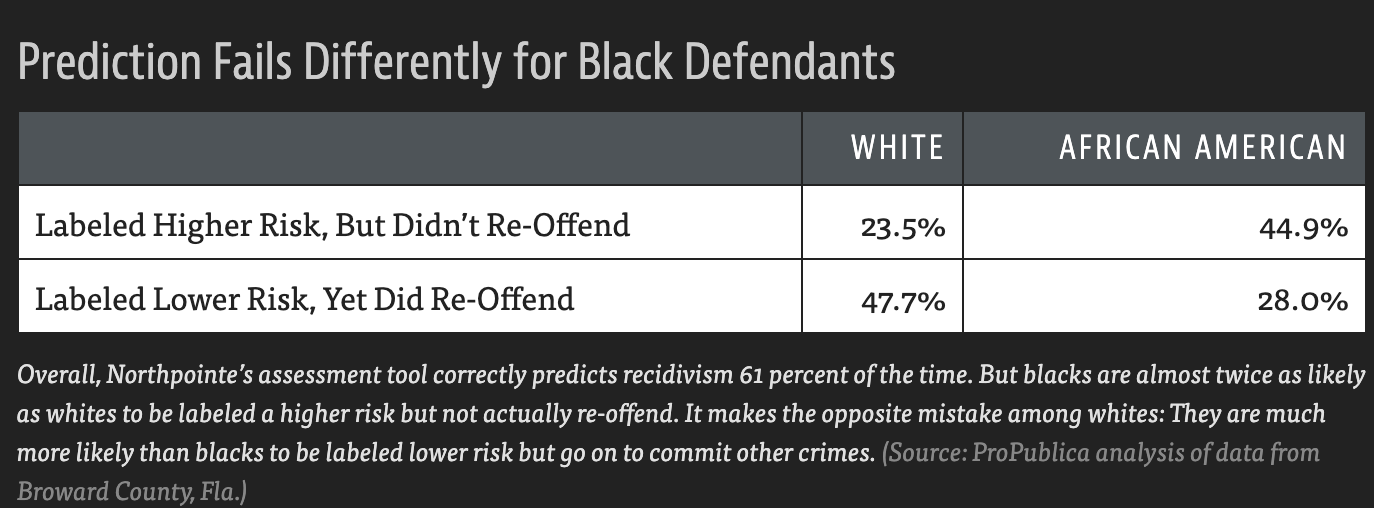

In the first part of this notebokk, we will go through parts of ProPublica's analysis of COMPAS, focusing on how the recidivism risk scale varies by race and sex: 

1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the COMPAS recidivism score, our primary variable of interest
3. Reproduce the logistic regression model in ProPublica's analysis and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

### Setup

In [1]:
# import libraries
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Data 
Refer to the description of the [data collection methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). Salient points are highlighted below; see the full description from ProPublica for additional details.

> **Goal:** We looked at more than 10,000 criminal defendants in Broward County, Florida, and compared their predicted recidivism rates with the rate that actually occurred over a two-year period.
>
> **COMPAS tool input (data subjects):** When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of Risk of Recidivism and Risk of Violent Recidivism.
>
> **How COMPAS input was acquired by ProPublica:** Through a public records request, ProPublica obtained two years worth of COMPAS scores from the Broward County Sheriff’s Office in Florida. We received data for all 18,610 people who were scored in 2013 and 2014.
>
> **COMPAS tool output:** Each pretrial defendant received at least three COMPAS scores: "Risk of Recidivism," "Risk of Violence" and "Risk of Failure to Appear. [...] COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as "Low;" 5 to 7 were labeled “Medium;" and 8 to 10 were labeled “High.”
>
> **Data integration (record linkage):** Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016. On average, defendants in our dataset were not incarcerated for 622.87 days (sd: 329.19). We matched the criminal records to the COMPAS records using a person’s first and last names and date of birth. This is the same technique used in the Broward County COMPAS validation study conducted by researchers at Florida State University in 2010. We downloaded around 80,000 criminal records from the Broward County Clerk’s Office website.
>
> **What is recidivism?** Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored. [...] For most of our analysis, we defined recidivism as a new arrest within two years.

Now let's import the data from ProPublica's compas-analysis repository on GitHub and check the first few rows:

In [2]:
## load the data 
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)
print("Shape: ", df_compas.shape)
df_compas.head(5)

Shape:  (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


Here is a table of variable definitions:

| Variable    | Description |
| ----------- | ----------- |
| age       |  Age of the defendant   |
| age_cat   |  Age category. It can be < 25, 25-45, >45    |
| sex   |  Sex of the defendant. It is either "Male" or "Female"       |
| race   |  Race of the defendant. It can be "African-American", "Caucasian", "Hispanic", "Asian", or "Other"      |
| c_charge_degree   |   Charge. Either "M" for misdemeanor, "F" for felony, or "O" (not causing jail time)    |
| priors_count   |   Count of prior crimes committed by the defendant      |
| days_b_screening_arrest   |  Days between the arrest and COMPAS screening       |
| decile_score   |  The COMPAS score estimated by the system. It is between 0-10       |
| score_text   |  Decile score. It can be "Low" (1-4), "Medium" (5-7), or "High" (8-10)       |
| is_recid   |  Indicates if the defendant recidivated. It can be 0, 1, or -1      |
| two_year_recid   |  Indicates if the defendant recidivated within two years of COMPAS assessment      |
| c_jail_in   |   Date the defendant was in jail      |
| c_jail_out  |   Date when the defendant was released from jail     |

\

Let's plot the distribution of some key variables: ```age```, ```race```, and ```sex```

<Axes: ylabel='Frequency'>

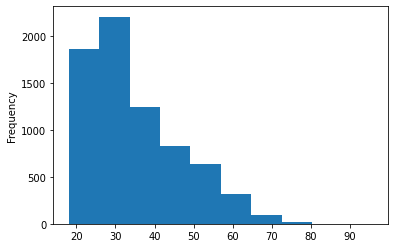

In [3]:
df_compas['age'].plot.hist()

<Axes: >

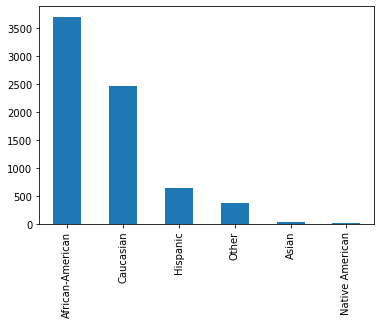

In [4]:
df_compas['race'].value_counts().plot(kind='bar')


<Axes: >

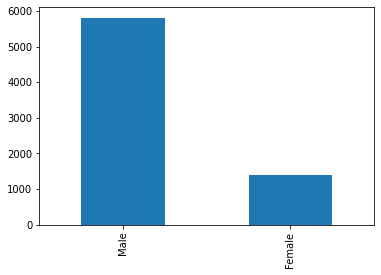

In [5]:
df_compas['sex'].value_counts().plot(kind='bar')


**Discuss:** what do you make of these distributions? Do you see any potential issues? Why might the distributions look this way?

### Preprocess Data

Now we'll apply preprocessing steps similar to what ProPublica did in their analysis. First, we'll select a subset of variables of interest: ```id```, ```age```, ```c_charge_degree```, ```race```, ```age_cat```, ```score_text```, ```sex```, ```priors_count```, ```days_b_screening_arrest```, ```decile_score```, ```is_recid```, and ```two_year_recid```

In [6]:
## select columns
cols_to_keep = ["id", "age", "c_charge_degree", "race", "age_cat", "score_text",
                "sex", "priors_count", "days_b_screening_arrest",
                "decile_score", "is_recid", "two_year_recid"]

df_selected = df_compas[cols_to_keep].copy()

print("Shape: ", df_selected.shape)
df_selected.head()

Shape:  (7214, 12)


,id,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
0,1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1
2,4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
3,5,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0
4,6,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0


Now we'll apply some filtering. We'll remove columns where: 
1. The COMPAS score is missing.
2. The charge date of the defendant's COMPAS-scored crime was not within 30 days from the date of arrest. ProPublica assumed that the offense may not be correct in these cases.
3. The recividist flag is "-1". In such cases, ProPublica could not find a COMPAS record at all.
4. The charge is "O". These are ordinary traffic offenses and do not result in jail time.

In [7]:
df_analysis = df_selected[
    (df_selected.score_text != "N/A") &
    (df_selected.days_b_screening_arrest <= 30) &
    (df_selected.days_b_screening_arrest >= -30) &
    (df_selected.is_recid != -1) &
    (df_selected.c_charge_degree != "O")
    ].copy()

Note that ProPublica only included people who had recidivated within two years or had at least two years outside a correctional facility. This pre-processing step is "baked in" to the data that we imported from GitHub in this notebook.

Take the additional step of making sure that the decile score is numeric:


In [8]:
df_analysis["decile_score"] = pd.to_numeric(df_analysis["decile_score"])

### Inspect the data again
Re-inspect salient variables in the data after the preprocessing steps. Plot the distribution of age, race, and sex in the preprocessed data (```df_analysis```) and compare these distributions to the imported data (```df_compas```):

<Axes: ylabel='Frequency'>

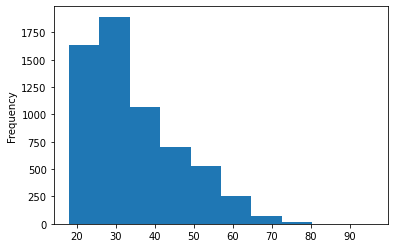

In [9]:
df_analysis['age'].plot.hist()

<Axes: >

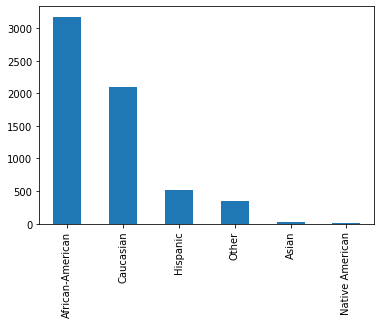

In [10]:
df_analysis['race'].value_counts().plot(kind='bar')


<Axes: >

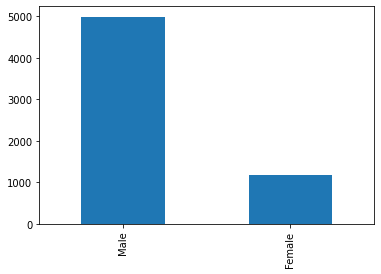

In [11]:
df_analysis['sex'].value_counts().plot(kind='bar')

**Discuss:** did anything change in these distributions after applying our data cleaning steps?    

We can also generate a crosstab summarizing the number of observations by race and sex to make it easier to analyze:

In [12]:
pd.crosstab(df_analysis.sex, df_analysis.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


**Discuss:** what do you make of these numbers? What limits should this place on our model building or the trust we put in the model's predictions?   

### Exploratory Analysis
Let's turn our focus to the primary variable of interest: the COMPAS recidivism score. In this exploratory analysis, we are interested in the variable named "decile_score".

The ProPublica analysis notes: "Judges are often presented with two sets of scores from the COMPAS system: one that classifies people into high, medium or low risk, and a corresponding decile score." A decile rank arranges the data in order from lowest to highest and is done on a scale of one to 10 where each successive number corresponds to an increase of 10 percentage points. 

Let's plot the distribution of decile score for males and for females.

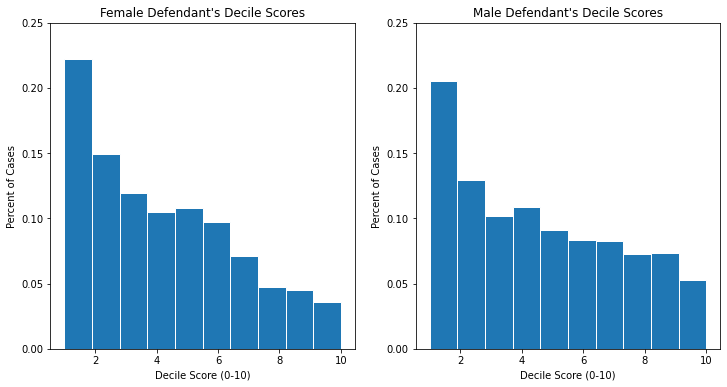

In [13]:
# plot score decile by sex
df_female = df_analysis[(df_analysis.sex == "Female")].copy()
df_male   = df_analysis[(df_analysis.sex == "Male")].copy()

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_female["decile_score"], ec = "white",
         weights = np.ones(len(df_female["decile_score"])) /
         len(df_female["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Female Defendant's Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_male["decile_score"], ec = "white",
         weights = np.ones(len(df_male["decile_score"])) /
         len(df_male["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Male Defendant's Decile Scores")
plt.ylim([0, 0.25])

plt.show()

**Discuss:** How do these distributions compare to each other? What does this imply fairness of the COMPAS predictions?    

What about race? We can repeat the above plots for Black defendants and White defendants:

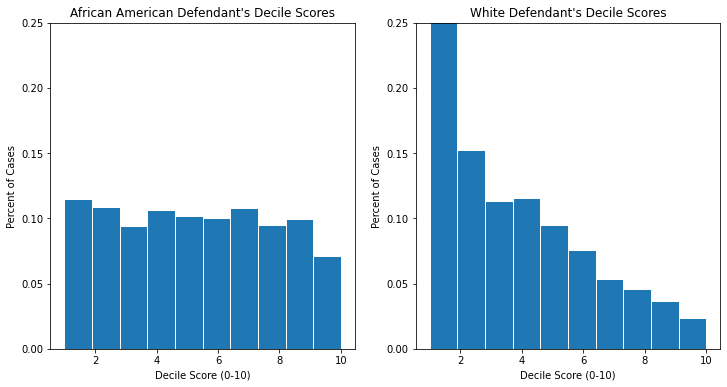

In [14]:
# plot score decile by race
df_aa = df_analysis[(df_analysis.race == "African-American")].copy()
df_white   = df_analysis[(df_analysis.race == "Caucasian")].copy()

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_aa["decile_score"], ec = "white",
         weights = np.ones(len(df_aa["decile_score"])) /
         len(df_aa["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("African American Defendant's Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_white["decile_score"], ec = "white",
         weights = np.ones(len(df_white["decile_score"])) /
         len(df_white["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("White Defendant's Decile Scores")
plt.ylim([0, 0.25])

plt.show()

**Discuss:** What do you make of these distributions? What implications does this have for fairness of COMPAS? 

We can also look at the distribution of score categories (high, medium, low) by race (this variable is ```score_text```

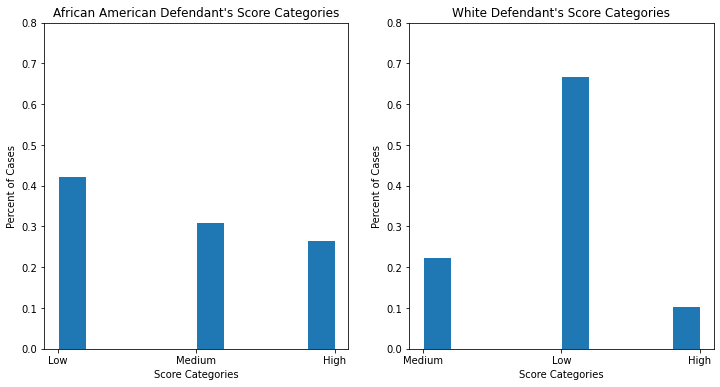

In [15]:
fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_aa["score_text"], ec = "white",
         weights = np.ones(len(df_aa["score_text"])) /
         len(df_aa["score_text"]))
plt.xlabel("Score Categories")
plt.ylabel("Percent of Cases")
plt.title("African American Defendant's Score Categories")
plt.ylim([0, 0.8])

fig.add_subplot(122)
plt.hist(df_white["score_text"], ec = "white",
         weights = np.ones(len(df_white["score_text"])) /
         len(df_white["score_text"]))
plt.xlabel("Score Categories")
plt.ylabel("Percent of Cases")
plt.title("White Defendant's Score Categories")
plt.ylim([0, 0.8])

plt.show()

## Bias Analysis
We've seen evidence that the risk score distributuons definitely vary by race. Ignoring the vast history of racism in the US justice system (which ABSOLUTELY is important, but beyond the scope of this particular analysis) to technically determine if COMPAS is `unfair' we need to look at whether or not these score distributions match what actually happens. 

Put another way, we want to measure the extent to which the *risk labels* assigned to defendants matches up with their observed recidivism and how this varies by race. We will reproduce a simplified version of ProPublica's analysis below.

### Preprocess Data for Logistic Regression

ProPublica used a logistic regression model to analyze variation in the risk scores by race. We will prepare the data by one-hot encoding the categorical variables.

In [16]:
## check data type of our data
print(df_analysis.dtypes)

id                           int64
age                          int64
c_charge_degree             object
race                        object
age_cat                     object
score_text                  object
sex                         object
priors_count                 int64
days_b_screening_arrest    float64
decile_score                 int64
is_recid                     int64
two_year_recid               int64
dtype: object


In [17]:
## see the columns we need to one-hot encode and how many values they each take
for i, col_type in enumerate(df_analysis.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            df_analysis.columns[i],
            df_analysis[df_analysis.columns[i]].unique()))


Variable c_charge_degree takes the values: ['F' 'M']

Variable race takes the values: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']

Variable age_cat takes the values: ['Greater than 45' '25 - 45' 'Less than 25']

Variable score_text takes the values: ['Low' 'Medium' 'High']

Variable sex takes the values: ['Male' 'Female']


In [18]:
## make a copy of the dataframe to hold our one-hot encoded variables
df_logistic = df_analysis.copy()

# one-hot encoding using pandas get_dummies function
df_logistic = pd.get_dummies(df_logistic,
                             columns = ["c_charge_degree", "race",
                                        "age_cat", "sex"])

# mutate score_text to binary variable where low = {low}
# and high = {medium, high}
df_logistic["score_binary"] = np.where(df_logistic["score_text"] != "Low",
                                       "High", "Low")
df_logistic["score_binary"] = df_logistic["score_binary"].astype('category')

# rename the columns to be more instructive and consistent with statsmodel
# requirements for variable names
df_logistic.columns = df_logistic.columns.str.replace(' ', '_')
df_logistic.columns = df_logistic.columns.str.replace('-', '_')

renamed_cols = {'age_cat_25___45':'age_cat_25_to_45',
                'c_charge_degree_F':'Felony',
                'c_charge_degree_M':'Misdemeanor'}

df_logistic = df_logistic.rename(columns = renamed_cols)

Check that recoding resulted in the desired data structure:


In [19]:
df_logistic.head()

,id,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,Felony,Misdemeanor,...,race_Caucasian,race_Hispanic,race_Native_American,race_Other,age_cat_25_to_45,age_cat_Greater_than_45,age_cat_Less_than_25,sex_Female,sex_Male,score_binary
0,1,69,Low,0,-1.0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,Low
1,3,34,Low,0,-1.0,3,1,1,1,0,...,0,0,0,0,1,0,0,0,1,Low
2,4,24,Low,4,-1.0,4,1,1,1,0,...,0,0,0,0,0,0,1,0,1,Low
5,7,44,Low,0,0.0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,1,Low
6,8,41,Medium,14,-1.0,6,1,1,1,0,...,1,0,0,0,1,0,0,0,1,High


## Estimate Logistic Regression Model

Now that our data is properly formatted, we can setup a model. We have to specify our own model because we do not have access to the actual COMPAS model. However, we do have their score predictions and input variables, so we can approximate the original model by building a logistic regression model of the COMPAS scores. As long as the accuracy of our logistic model is high, it's.a good approximation for the true COMPAS model. If you need a refresher on logistic regression, check out this [overview](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc).

Following ProPublica, we specify the following model:

In [20]:
# Right-hand side
explanatory = "priors_count + two_year_recid + Misdemeanor + \
age_cat_Greater_than_45 + age_cat_Less_than_25 + \
race_African_American + race_Asian + race_Hispanic + race_Native_American + \
race_Other + sex_Female"

# Left-hand side
response = "score_binary"

# Formula
formula = response + " ~ " + explanatory
print(formula)

score_binary ~ priors_count + two_year_recid + Misdemeanor + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + sex_Female


Now we can fit the model

In [21]:
# Note: using family = sm.families.Binomial() specifies a logistic regression
model = sm.formula.glm(formula = formula, 
                       family = sm.families.Binomial(),
                       data = df_logistic).fit()

print(model.summary())

                              Generalized Linear Model Regression Results                              
Dep. Variable:     ['score_binary[High]', 'score_binary[Low]']   No. Observations:                 6172
Model:                                                     GLM   Df Residuals:                     6160
Model Family:                                         Binomial   Df Model:                           11
Link Function:                                           Logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -3084.2
Date:                                         Fri, 03 Mar 2023   Deviance:                       6168.4
Time:                                                 14:04:25   Pearson chi2:                 6.07e+03
No. Iterations:                                              6   Pseudo R-squ. (CS):             0.3128
Covariance Type:                                     nonrobust  

**Discuss:** what do these numbers mean? How accurate is our logistic regression model? Which variables are most useful for predicting the COMPAS scores? 

One way to interpret the estimates is by calculating odds ratios. To calculate odds ratios, we take the exponential of the coefficients. For example, taking the exponential of the coefficient for sex_Female ($\beta_{female}$ = 0.2213) will return the odds of score_text taking the value "high" for a female relative to a male. Note that an odds ratio less than 1 indicates that the group in question is less likely to have a high risk score than the rest of the individuals in dataset. We can calculate this odds ratio here:

In [22]:
or_female=math.exp(0.2213)
print("odds ratio for females: ", or_female)

odds ratio for females:  1.247697683728402


In words, the odds that COMPAS labeled a defendant as "high risk" of recidivism is 1.25 times greater for a female than a male.

We can repeat thus calculation of the odds ratio for all of the coefficients in the model:

In [23]:
print(np.exp(model.params))

Intercept                  0.217504
priors_count               1.308584
two_year_recid             1.985484
Misdemeanor                0.732537
age_cat_Greater_than_45    0.257784
age_cat_Less_than_25       3.700213
race_African_American      1.611567
race_Asian                 0.775370
race_Hispanic              0.651554
race_Native_American       4.031779
race_Other                 0.437645
sex_Female                 1.247656
dtype: float64


We often think about bias in algorithmic systems in three ways: 

1.   pre-existing bias: exists independently of algorithm, has origins in society
2.   technical bias: introduced or exacerbated by the technical properties of an algorithm
3.   emerging bias: arises due to context of use

**Discuss:** how do these odds ratios relate to these types of bias? 

### Predictive Accuracy

In terms of fairness, ProPublica focused the predictive accuracy of the COMPAS algorithm. In this case, predictive accuracy refers to the concordance between a person's recidivism and the label assigned to that person by the COMPAS algorithm. For instance, how often did COMPAS predict that a person was at "high risk" of recidivism and that person in fact recidivated within two years? We can think of this in terms of a 2x2 table:

|      | Did not recidivate | Recidivated   |
| :---        |    :----:   |          ---: |
| **Labeled high risk**  | A       | B   |
| **Labeled low risk**   | C       | D      |

ProPublica reported A and D for black defendants and white defendants, separately.

**Discuss** What are generic terms for A and D? Why focus on A and D?

ProPublica used a somewhat different data set to calculate the predictive accuracy of COMPAS (you can read the full details of their analysis [here](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). In this section we will use the ```df_logistic``` data we preprocessed above for brevity. Note therefore that the numbers we calculate below will not match those reported by ProPublica. Let's generate a crosstab of the variable denoting recidivism within two years (```is_recid``` where 0 means did not recidivate and 1 means did recidivate) and the binary score variable (```score_binary```):

In [24]:
print("All defendants")
pd.crosstab(df_logistic["score_binary"], df_logistic["is_recid"])

All defendants


is_recid,0,1
score_binary,,
High,934,1817
Low,2248,1173


Based on this crosstab, input the number of true positives, false positives, 
true negatives, and false negatives:

In [25]:
true_positive  = 0#@param {type:"number"}
false_positive = 0#@param {type:"number"}
true_negative  = 0#@param {type:"number"}
false_negative = 0#@param {type:"number"}

We can calculate the false positive rate by taking FP / (FP + TN), where FP is the number of false positives and TN is the number of true negatives:

In [26]:
fp_rate=934/(934+2248)
print("false positive rate: ",fp_rate)

false positive rate:  0.29352608422375864


Similarly, we can calculate the false negative rate by taking FN / (FN + TP)

In [27]:
fn_rate=1173/(1173+1817)
print("false negative rate: ", fn_rate)

false negative rate:  0.3923076923076923


**Discuss:** what does this tell us about how reliable the model is? Do the different rates raise any concerns? 

Now let's look at how the false positive and false negative rates vary by sex. Let's generate a crosstab of "score_binary" and "is_recid" for female defendants:

In [28]:
mask = df_logistic["sex_Female"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("Female defendants")

is_recid        0    1
score_binary          
High          220  256
Low           520  179
Female defendants


Based on this crosstab, calculate the false positive and false negative rates for females:

In [29]:
fp_rate=220/(220+520)
print("false positive rate for women: ",fp_rate)
fn_rate=179/(179+256)
print("false negative rate for women: ", fn_rate)

false positive rate for women:  0.2972972972972973
false negative rate for women:  0.4114942528735632


Pretty close to the false positive and false negative rates for the whole dataset. Now let's do the same thing for male defendants: 



In [30]:
mask = df_logistic["sex_Male"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("Male defendants")

is_recid         0     1
score_binary            
High           714  1561
Low           1728   994
Male defendants


In [31]:
fp_rate=714/(714+1738)
print("false positive rate for men: ",fp_rate)
fn_rate=994/(994+1561)
print("false negative rate for women: ", fn_rate)

false positive rate for men:  0.2911908646003263
false negative rate for women:  0.38904109589041097


**Discuss:** what do you notice about these rates? What does that mean about the fairness of COMPAS across genders? Are there any caveats you would give for these numbers?



Now we can repeat the same analysis for race. First we'll calculate the rates for white defendants:

In [32]:
mask = df_logistic["race_Caucasian"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("White defendants")

is_recid        0    1
score_binary          
High          266  430
Low           963  444
White defendants


In [33]:
fp_rate=266/(266+963)
print("false positive rate for caucasians: ",fp_rate)
fn_rate=444/(444+430)
print("false negative rate for caucasians: ", fn_rate)

false positive rate for caucasians:  0.21643612693246542
false negative rate for caucasians:  0.5080091533180778


And finally we'll calculate the rates for black defendants:

In [34]:
mask = df_logistic["race_African_American"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("Black defendants")

is_recid        0     1
score_binary           
High          581  1248
Low           821   525
Black defendants


In [35]:
fp_rate=581/(581+821)
print("false positive rate for African Americans: ",fp_rate)
fn_rate=525/(525+1248)
print("false negative rate for African Americans: ", fn_rate)

false positive rate for African Americans:  0.4144079885877318
false negative rate for African Americans:  0.2961082910321489


**Discuss:** what do you notice about these rates? What does that mean about the fairness of COMPAS across races? Are there any caveats you would give for these numbers? Do you agree with ProPublica's conclusion that COMPAS is racially biased? How would you address these concerns? 

To wrap up, take a few minutes to explore the related MIT Technology Review article "[Can you make AI fairer than a judge?](https://www.technologyreview.com/2019/10/17/75285/ai-fairer-than-judge-criminal-risk-assessment-algorithm/)". What questions does this bring up about how we should approach building fair algorithmic systems? What role do you think regulation should play? 